In [1]:
"""
Script extracting wavenumbers, temperature, hot/cold status from temperature '.log' and raw spectra '.txt' files
"""
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import math as m
import pandas as pd
import glob
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import itertools
from scipy import interpolate
import matplotlib.cm as cm

 
import csv

In [2]:
# VARIABLES

file_name = 'IC_raw_spectra_(2019_02_25_'

#path_raw = 'H:/MSci Project/sand_outside' #path containing all raw spectra RACHEL
path_raw = '/Users/micol/Documents/Imperial/Year4/Master_Project/sand_outside' #path containing all raw spectra

file_path_tau = path_raw + "/Laura_simulations"
#path_sensitivity = 'H:/MSci Project/Sensitivity_Analysis'
path_sensitivity = '/Users/micol/Documents/Imperial/Year4/Master_Project/sand_outside/Sensitivity_Analysis'

In [3]:
#FUNCTIONS

def read_file(directory, filename, separator, rowstoskip, head='infer'):
    """
    Reads an external file and outputs it as a Pandas Dataframe
    Input: Directory, Filename (Strings)
    Output: Pandas Dataframe
    """
    path=os.path.join(directory, filename)
    dataset = pd.read_csv(path, header = head, sep=separator, skiprows=rowstoskip)
    
    return dataset


def planck(wavenumber, temperature): # T in Kelvin, wavenumber in cm^-1
    """
    Calculates spectral radiance of a black body at some wavenumber and temperature
    Input: wavenumber (units: cm^{-1}), and temperature T (units: Kelvin) - (Integers or Floats)
    Output: spectral radiance (units: W m^{-2} sr^{-1} cm^{-1}) - (Float)
    """
    h = 6.626e-34
    c = 3.0e+8
    k = 1.381e-23

    planck_a = 2*h*(c**2)
    planck_e = h*c/k
    radiance = 100*planck_a*((wavenumber*100)**3)/(np.exp(planck_e*(wavenumber*100)/temperature)-1)

    return radiance


def read_raw_spectra(directory, filename):
    """
    Reads spectrum file and calculates the average of the 4 spectra
    Input: Directory, Filename (Strings)
    Output: average_spectrum (NumPy Array)
    """
    file_data = read_file(path_raw, filename, separator='  ', rowstoskip=5, head=None)
    spectrum1 = file_data[1].values
    spectrum2 = file_data[2].values
    spectrum3 = file_data[3].values
    spectrum4 = file_data[4].values
    
    return spectrum1,spectrum2,spectrum3,spectrum4

In [4]:
def inv_resp_function(hbb_spectrum, cbb_spectrum):
    
    V_diff = np.array(hbb_spectrum)-np.array(cbb_spectrum)
    
    temp_average_h = times_temps.at[hbb_index,'HBB_temp']
    temp_average_c = times_temps.at[cbb_index,'CBB_temp']

    radiances_avg_h = [planck(wn, float(temp_average_h)+273.15) for wn in wavenums_cut]
    radiances_avg_c = [planck(wn, float(temp_average_c)+273.15) for wn in wavenums_cut]
    rad_diff = np.array(radiances_avg_h) - np.array(radiances_avg_c)

    def division(raw_val,planck_val):
        if raw_val == 0:
            div = 0
        else:
            div = raw_val/planck_val
        return div

    division_vec = np.vectorize(division)
    ratio = division_vec(V_diff, rad_diff)

    return(ratio)


def plot_planck(t, wns):
    radiances = []
    for w in wns:
        radiances.append(planck(w, t+273.15))
    return radiances

In [5]:
#create list of file paths starting with file_name from 'path_raw' directory
measurements = len(glob.glob(path_raw + '/'+ file_name + '*')) #filepaths of all 'IC_raw_spectra' files
m_numbers = list(range(measurements)) #list of file name endings (integers)

for i in m_numbers:
    #checks that files have associated temperature measurements, and removes the files if not
    temp_check = read_file(path_raw, file_name + '{0:03}'.format(i) + '.txt', separator=',', rowstoskip=None, head=None).iloc[1,0]
    temp_check_float = float(temp_check.split()[0])
    if temp_check_float == 0.0:
        m_numbers.pop(i)

files = [file_name + '{0:03}'.format(num) + '.txt' for num in m_numbers][:-2] #final list of strings of file names, in order

In [6]:
columns_ = ['RT0','RT1','RT2','Dummy','RT3','RT4','HBB_temp','CBB_temp','Time', 'Orientation'] #columns for Pandas DataFrame

read_temps = []

for i in np.arange(0,len(files)):
    #Go through files and retrieve temperatures and orientations of spectra
    read_temps.append( read_file(path_raw, files[i], separator=',', rowstoskip=None, head=None).iloc[1:5,0].str.split() )
    read_temps_flat = list(itertools.chain(*read_temps)) #flatten read_temps_i

times_temps = pd.DataFrame(read_temps_flat, columns = columns_)

In [7]:
wavenums = read_file(path_raw, files[0], separator='  ', rowstoskip=5, head=None)[0].values

/Users/micol/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


In [8]:
wavenums_cut = [wn for wn in wavenums if wn>400]
wavenums_min_ind = [i for i,x in enumerate(wavenums) if x >400][0]

plt.figure(figsize=(15,10))
all_ems = []

t_file = '2103_3063'
hbb_index = 528
cbb_index = 519
sky_index = 503
surface_index = 525
atm_t = 21.03 #21.03
surf_t = 17.3 #17.3
#time = '15:07'


hbb_spectrum = read_raw_spectra(path_raw, files[int(np.floor(hbb_index/4))])[hbb_index%4][wavenums_min_ind:]
cbb_spectrum = read_raw_spectra(path_raw, files[int(np.floor(cbb_index/4))])[cbb_index%4][wavenums_min_ind:]
response = inv_resp_function(hbb_spectrum, cbb_spectrum)

temp_average_h = times_temps.at[hbb_index,'HBB_temp']
radiances_avg_h = np.array([planck(wn, float(temp_average_h)+273.15) for wn in wavenums_cut])

sky = read_raw_spectra(path_raw, files[int(np.floor(sky_index/4))])[sky_index%4][wavenums_min_ind:]
surf = read_raw_spectra(path_raw, files[int(np.floor(surface_index/4))])[surface_index%4][wavenums_min_ind:]

sky_rad = np.divide((sky-hbb_spectrum), response) + radiances_avg_h
surf_rad = np.divide((surf-hbb_spectrum), response) + radiances_avg_h

tau_wn= []
taus_rtm = []
trans_file = np.loadtxt(file_path_tau + '/' + t_file +'.txt')
for i in np.arange(trans_file.shape[0]):
    tau_wn.append(trans_file[i][0])
    taus_rtm.append(trans_file[i][1])
f_trans = interpolate.interp1d(tau_wn, taus_rtm)


pert_down = 1.00 #1
pert_up = 1.00
pert_tau = 1.00

downs = []
ups = []
taus = []
wns =[]
for i in range(len(wavenums_cut)):
    if f_trans(wavenums_cut[i]) >0.98:
        taus.append(f_trans(wavenums_cut[i]) * pert_tau)
        wns.append(wavenums_cut[i])
        downs.append(sky_rad[i] * pert_down)
        ups.append(surf_rad[i] * pert_up)

        
BBatm = plot_planck(atm_t, wns)
BBsurf = plot_planck(surf_t, wns)

N1 = np.array(ups)
N2 = np.array([t**2*d for t, d in zip(taus, downs)])
N3 = np.array([(1-t**2)*b for t, b in zip(taus, BBatm)])

N = N1-N2-N3

D1 = np.array([t*b for t, b in zip(taus, BBsurf)])
D2 = np.array([t**2*d for t, d in zip(taus, downs)])
D3 = np.array([t*(1-t)*b for t, b in zip(taus, BBatm)])

D = D1-D2-D3

emissivity = N/D


"""with open(os.path.join(path_sensitivity, 'Tau_' + str(pert_tau) + '.csv'), "w") as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerows(zip(wns,emissivity))"""

"""with open(os.path.join(path_sensitivity, 'Down_' + str(pert_down) + '.csv'), "w") as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerows(zip(wns,emissivity))"""
"""
with open(os.path.join(path_sensitivity, 'Up_' + str(pert_up) + '.csv'), "w") as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerows(zip(wns,emissivity))"""

/Users/micol/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


'\nwith open(os.path.join(path_sensitivity, \'Up_\' + str(pert_up) + \'.csv\'), "w") as f:\n    writer = csv.writer(f, delimiter=\'\t\')\n    writer.writerows(zip(wns,emissivity))'

with open(os.path.join(path_sensitivity, 'Surf_T_' + str(surf_t) + '.csv'), "w") as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerows(zip(wns,emissivity))

In [9]:
perturbs = sorted(glob.glob(path_sensitivity + '/' + 'Surf_T_' + '*'))

perturbed_ts = []
perturbed_lists = []
for file in perturbs:
    file_end = os.path.basename(file)
    perturbed_lists.append(read_file(path_sensitivity, file_end, separator = '\t', rowstoskip=None, head=None))
    perturbed_ts.append(file_end.strip('Surf_T_.csv'))

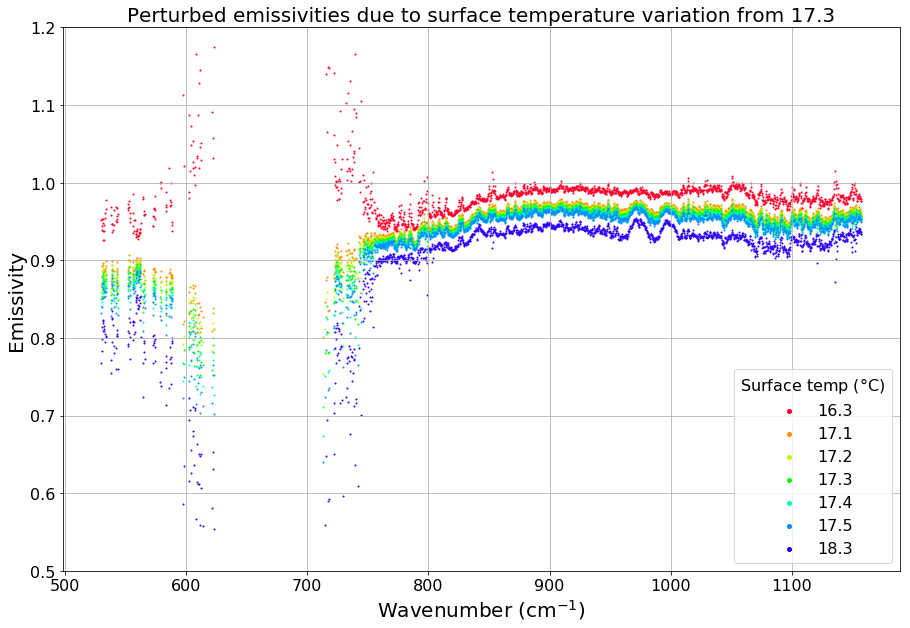

In [10]:
colors = cm.gist_rainbow(np.linspace(0, .8, len(perturbed_ts))) # last number is number of colours you want

fig = plt.figure(figsize=(15,10))

for (l,name, color) in zip(perturbed_lists, perturbed_ts, colors):
    plt.scatter(l[0], l[1], s=1, label=name, c=color)
    
plt.title('Perturbed emissivities due to surface temperature variation from 17.3', fontsize=20)
plt.ylabel('Emissivity', fontsize=20)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
plt.tick_params(labelsize=16, labelcolor='black')

legend = plt.legend(fontsize=16, title='Surface temp ($\degree$C)', markerscale=4)
plt.setp(legend.get_title(),fontsize=16)
plt.ylim(0.5,1.2)
plt.grid()
fig.savefig('Graphs/Pert_Surf_temp.png', dpi=600)
plt.show()

plot d emissivity by dts for a certain wavenumeber,. 

what we are looking at is unceratinty due to uncertainty in a certain temperature

combine unceratinty total uncertainty in quadrature, and have error bars and break down how much is due to each term. ConlcusionL waht is the quantity that we need to measure better to imporve emissivities.

de;ta t against delta emissivity - could have it as a plot inside a plot

error due to temp measured a couple of centimeters into the water
best case uncertainty is 0.1 because that is the reading error. WOuld expect as you heat water and develop skin layer, top of water might be a bit warmer than water underneath. Have look in literature for skin temperature water to underneath, just so we can quote it. Ours is more likelty to be too cold. Would make our emissivity go down a bit.
probably doing better than 0.5 error.

DSay in future design find some way to look at stratification or alternatively mixing the water, maybe similar to Newman.

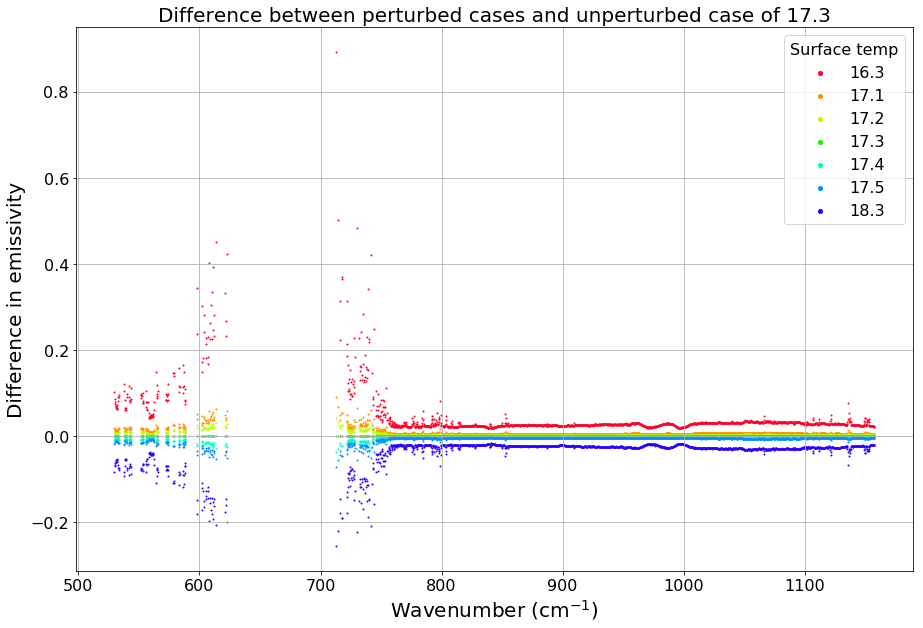

In [11]:
# Look at difference between each perturbation and the unperturbed one

colors = cm.gist_rainbow(np.linspace(0, .8, len(perturbed_lists))) # last number is number of colours you want
fig = plt.figure(figsize=(15,10))

for (l,name, color) in zip(perturbed_lists, perturbed_ts, colors):
    diff = [(a-b) for (a,b) in zip(l[1], perturbed_lists[3][1])]
    plt.scatter(l[0], diff, s=1, label=name, c=color)

plt.title('Difference between perturbed cases and unperturbed case of 17.3', fontsize=20)
plt.ylabel('Difference in emissivity', fontsize=20)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
plt.tick_params(labelsize=16, labelcolor='black')

legend = plt.legend(fontsize=16, title='Surface temp', markerscale=4)
plt.setp(legend.get_title(), fontsize=16)

#plt.ylim(0,1)
plt.grid()
fig.savefig('Graphs/Pert_Surf_temp_diff.png', dpi=600)
plt.show()

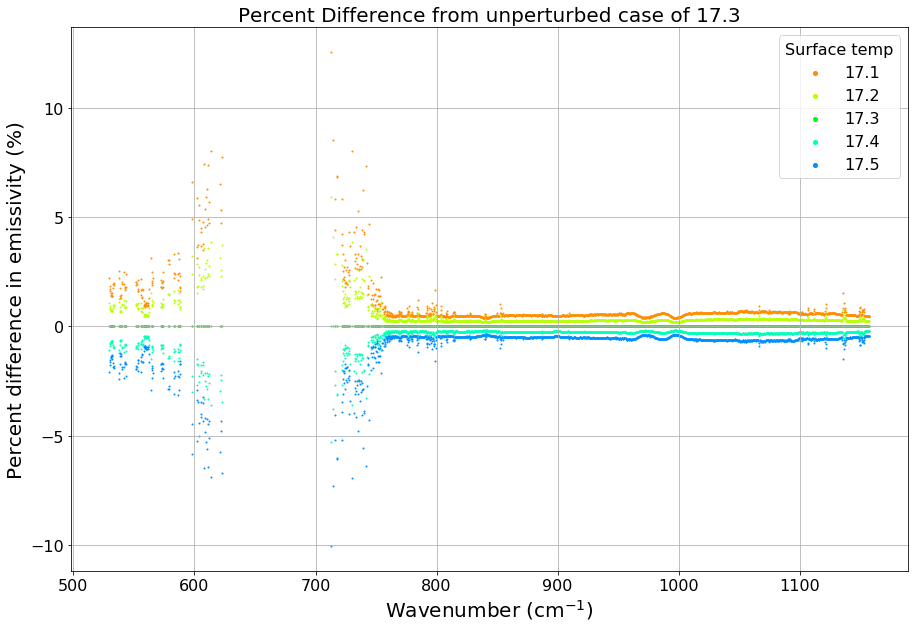

In [12]:
# Look at percentage deviation between each perturbation and the unperturbed one

colors = cm.gist_rainbow(np.linspace(0, .8, len(perturbed_lists)))

fig = plt.figure(figsize=(15,10))

for (l, name, color) in zip(perturbed_lists[1:-1], perturbed_ts[1:-1], colors[1:-1]):
    perc = [(a-b)/b*100 for (a,b) in zip(l[1], perturbed_lists[3][1])]
    plt.scatter(l[0], perc, s=1, label=name, c=color)

plt.title('Percent Difference from unperturbed case of 17.3', fontsize=20)
plt.ylabel('Percent difference in emissivity (%)', fontsize=20)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
plt.tick_params(labelsize=16, labelcolor='black')
legend = plt.legend(fontsize=16, title='Surface temp', markerscale=4)
plt.setp(legend.get_title(),fontsize=16)

#plt.ylim(0,1)
plt.grid()
fig.savefig('Graphs/Pert_Surf_temp_percentage.png', dpi=600)
plt.show()

with open(os.path.join(path_sensitivity, 'Atm_T_' + str(atm_t) + '.csv'), "w") as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerows(zip(wns,emissivity))

In [13]:
atm_files = sorted(glob.glob(path_sensitivity + '/' + 'Atm_T_' + '*'))

atm_names = []
perturbs_atm = []
for file in atm_files:
    file_end = os.path.basename(file)
    perturbs_atm.append(read_file(path_sensitivity, file_end, separator = '\t', rowstoskip=None, head=None))
    atm_names.append(file_end.strip('Atm_T_.csv'))

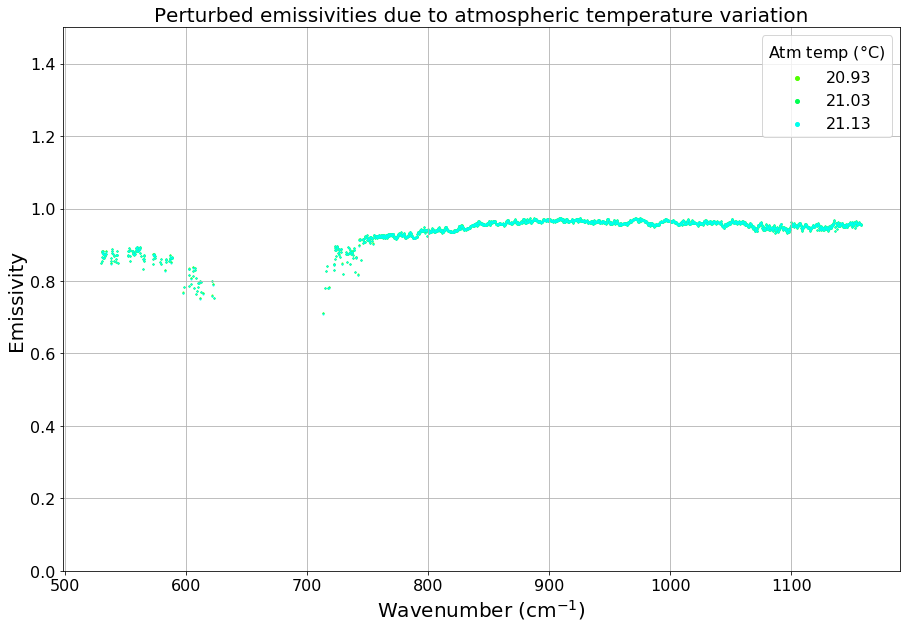

In [14]:
colors = cm.gist_rainbow(np.linspace(0, .8, len(perturbs_atm))) # last number is number of colours you want

fig = plt.figure(figsize=(15,10))

for (l,name, color) in zip(perturbs_atm[3:6], atm_names[3:6], colors[3:6]):
    plt.scatter(l[0], l[1], s=1, label=name, c=color)
    
plt.title('Perturbed emissivities due to atmospheric temperature variation', fontsize=20)
plt.ylabel('Emissivity', fontsize=20)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
plt.tick_params(labelsize=16, labelcolor='black')

legend = plt.legend(fontsize=16, title='Atm temp ($\degree$C)', markerscale=4)
plt.setp(legend.get_title(),fontsize=16)
plt.ylim(0.,1.5)
plt.grid()
fig.savefig('Graphs/Pert_Atm_temp.png', dpi=600)
plt.show()

In [15]:
#Not very sensitive to atmospheric temperature!! Try with bigger temperature variations:

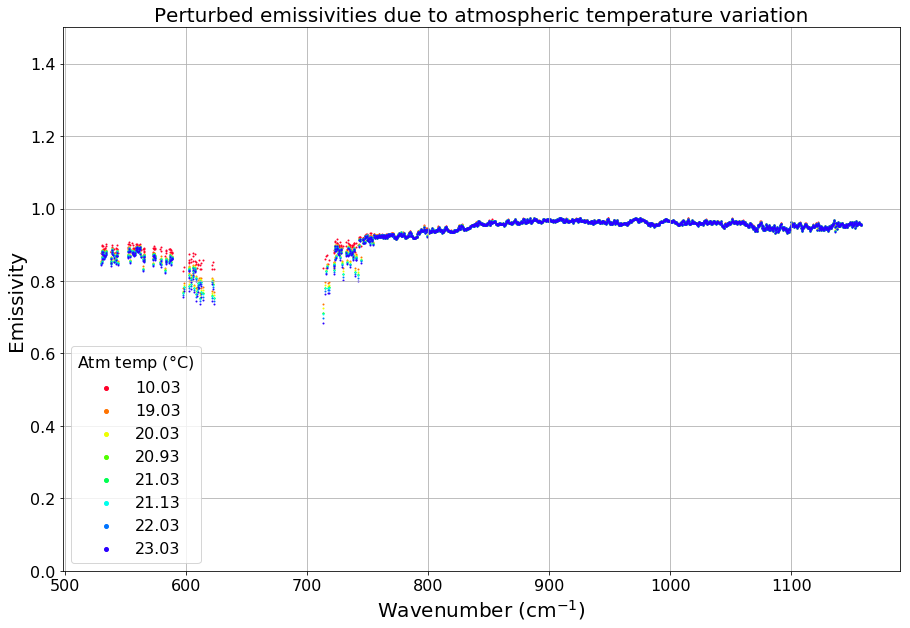

In [16]:
colors = cm.gist_rainbow(np.linspace(0, .8, len(perturbs_atm))) # last number is number of colours you want

fig = plt.figure(figsize=(15,10))

for (l,name, color) in zip(perturbs_atm, atm_names, colors):
    plt.scatter(l[0], l[1], s=1, label=name, c=color)
    
plt.title('Perturbed emissivities due to atmospheric temperature variation', fontsize=20)
plt.ylabel('Emissivity', fontsize=20)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
plt.tick_params(labelsize=16, labelcolor='black')

legend = plt.legend(fontsize=16, title='Atm temp ($\degree$C)', markerscale=4)
plt.setp(legend.get_title(),fontsize=16)
plt.ylim(0.,1.5)
plt.grid()
fig.savefig('Graphs/Pert_Atm_temp_1.png', dpi=600)
plt.show()

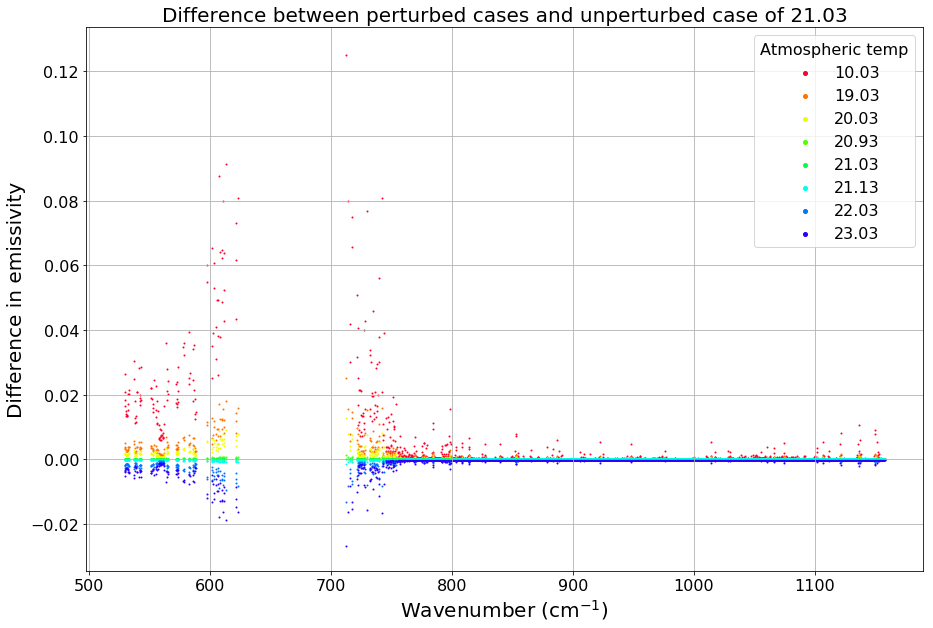

In [17]:
# Look at difference between each perturbation and the unperturbed one

colors = cm.gist_rainbow(np.linspace(0, .8, len(atm_files))) # last number is number of colours you want
fig = plt.figure(figsize=(15,10))

for (l,name, color) in zip(perturbs_atm, atm_names, colors):
    diff = [(a-b) for (a,b) in zip(l[1], perturbs_atm[4][1])]
    plt.scatter(l[0], diff, s=1, label=name, c=color)

plt.title('Difference between perturbed cases and unperturbed case of 21.03', fontsize=20)
plt.ylabel('Difference in emissivity', fontsize=20)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
plt.tick_params(labelsize=16, labelcolor='black')

legend = plt.legend(fontsize=16, title='Atmospheric temp', markerscale=4)
plt.setp(legend.get_title(), fontsize=16)

#plt.ylim(0,1)
plt.grid()
fig.savefig('Graphs/Pert_Atm_temp_diff.png', dpi=600)
plt.show()

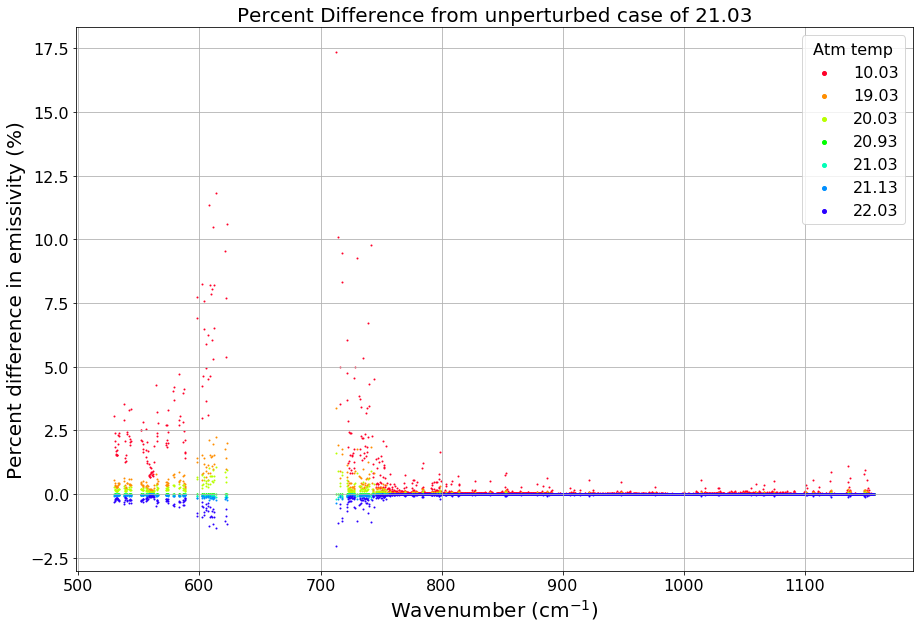

In [18]:
# Look at percentage deviation between each perturbation and the unperturbed one

colors = cm.gist_rainbow(np.linspace(0, .8, len(perturbed_lists)))

fig = plt.figure(figsize=(15,10))

for (l,name, color) in zip(perturbs_atm, atm_names, colors):
    perc = [(a-b)/b*100 for (a,b) in zip(l[1], perturbs_atm[3][1])]
    plt.scatter(l[0], perc, s=1, label=name, c=color)

plt.title('Percent Difference from unperturbed case of 21.03', fontsize=20)
plt.ylabel('Percent difference in emissivity (%)', fontsize=20)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
plt.tick_params(labelsize=16, labelcolor='black')
legend = plt.legend(fontsize=16, title='Atm temp', markerscale=4)
plt.setp(legend.get_title(),fontsize=16)

#plt.ylim(0,1)
plt.grid()
fig.savefig('Graphs/Pert_Atm_temp_percentage.png', dpi=600)
plt.show()

In [19]:
down_files = sorted(glob.glob(path_sensitivity + '/' + 'Down_' + '*'))

down_names = []
perturbs_down = []
for file in down_files:
    file_end = os.path.basename(file)
    perturbs_down.append(read_file(path_sensitivity, file_end, separator = '\t', rowstoskip=None, head=None))
    down_names.append(file_end.strip('Down_.csv'))

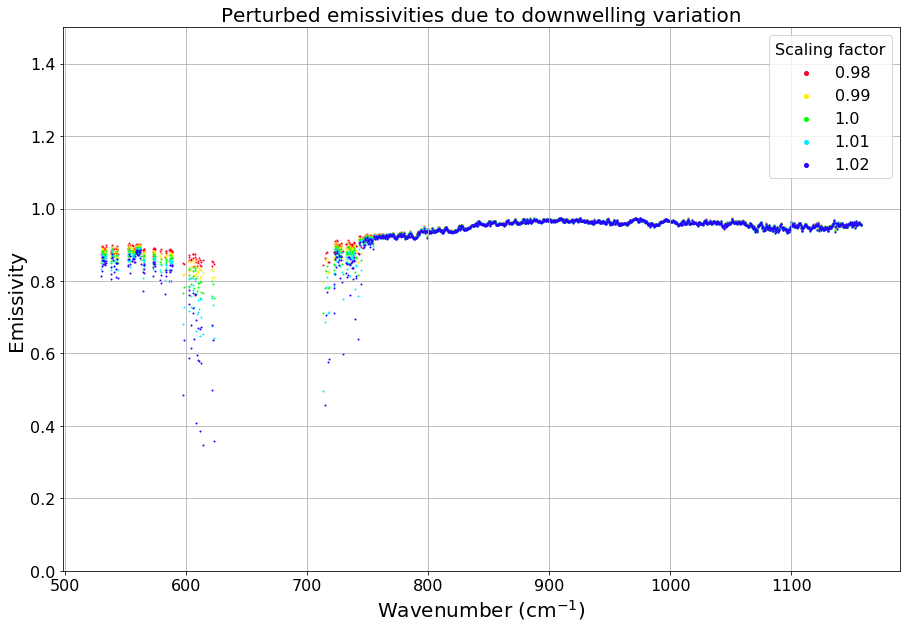

In [20]:
colors = cm.gist_rainbow(np.linspace(0, .8, len(perturbs_down))) # last number is number of colours you want

fig = plt.figure(figsize=(15,10))

for (l,name, color) in zip(perturbs_down, down_names, colors):
    plt.scatter(l[0], l[1], s=1, label=name, c=color)
    
plt.title('Perturbed emissivities due to downwelling variation', fontsize=20)
plt.ylabel('Emissivity', fontsize=20)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
plt.tick_params(labelsize=16, labelcolor='black')

legend = plt.legend(fontsize=16, title='Scaling factor', markerscale=4)
plt.setp(legend.get_title(),fontsize=16)
plt.ylim(0.,1.5)
plt.grid()
fig.savefig('Graphs/Pert_Downwelling.png', dpi=600)


plt.show()

shows that is more sensiitvie at low awvenumbers. to downwelling where teransmission i slower, Have bigger scale.

Look at noise equivalent spectral radiance from Jon.

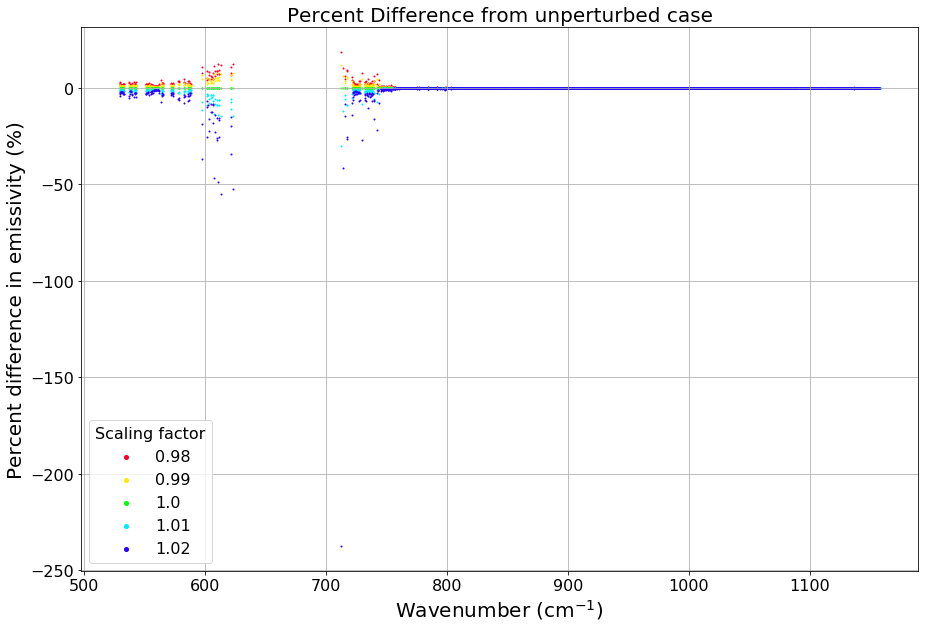

In [21]:
# Look at percentage deviation between each perturbation and the unperturbed one

colors = cm.gist_rainbow(np.linspace(0, .8, len(perturbs_down)))

fig = plt.figure(figsize=(15,10))

for (l,name, color) in zip(perturbs_down, down_names, colors):
    perc = [(a-b)/b*100 for (a,b) in zip(l[1], perturbs_down[2][1])]
    plt.scatter(l[0], perc, s=1, label=name, c=color)

plt.title('Percent Difference from unperturbed case', fontsize=20)
plt.ylabel('Percent difference in emissivity (%)', fontsize=20)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
plt.tick_params(labelsize=16, labelcolor='black')
legend = plt.legend(fontsize=16, title='Scaling factor', markerscale=4)
plt.setp(legend.get_title(),fontsize=16)

#plt.ylim(0,1)
plt.grid()
fig.savefig('Graphs/Pert_Downwelling_percentage.png', dpi=600)
plt.show()

See notes from NESR on jons word file
we may not have taken as many scans as jon - broad indicative idea. If it causes big errrors, can scale it but keep shape the same 

downwelling has t squaredd in front so more sensitive to upweeling 

In [22]:
up_files = sorted(glob.glob(path_sensitivity + '/' + 'Up_' + '*'))

up_names = []
perturbs_up = []
for file in up_files:
    file_end = os.path.basename(file)
    perturbs_up.append(read_file(path_sensitivity, file_end, separator = '\t', rowstoskip=None, head=None))
    up_names.append(file_end.strip('Up_.csv'))

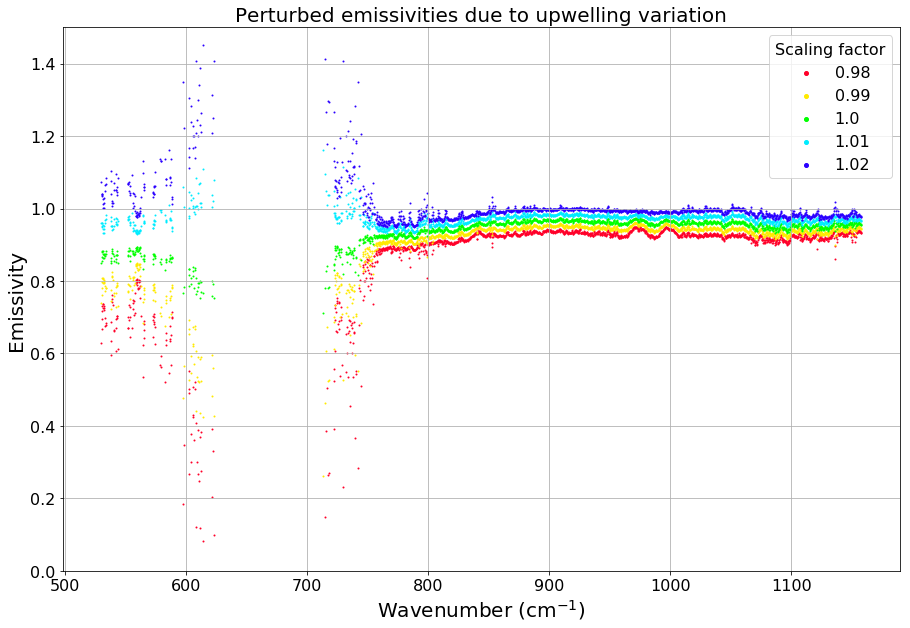

In [23]:
colors = cm.gist_rainbow(np.linspace(0, .8, len(perturbs_up))) # last number is number of colours you want

fig = plt.figure(figsize=(15,10))

for (l,name, color) in zip(perturbs_up, up_names, colors):
    plt.scatter(l[0], l[1], s=1, label=name, c=color)
    
plt.title('Perturbed emissivities due to upwelling variation', fontsize=20)
plt.ylabel('Emissivity', fontsize=20)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
plt.tick_params(labelsize=16, labelcolor='black')

legend = plt.legend(fontsize=16, title='Scaling factor', markerscale=4)
plt.setp(legend.get_title(),fontsize=16)
plt.ylim(0.,1.5)
plt.grid()
fig.savefig('Graphs/Pert_Upwelling.png', dpi=600)
plt.show()

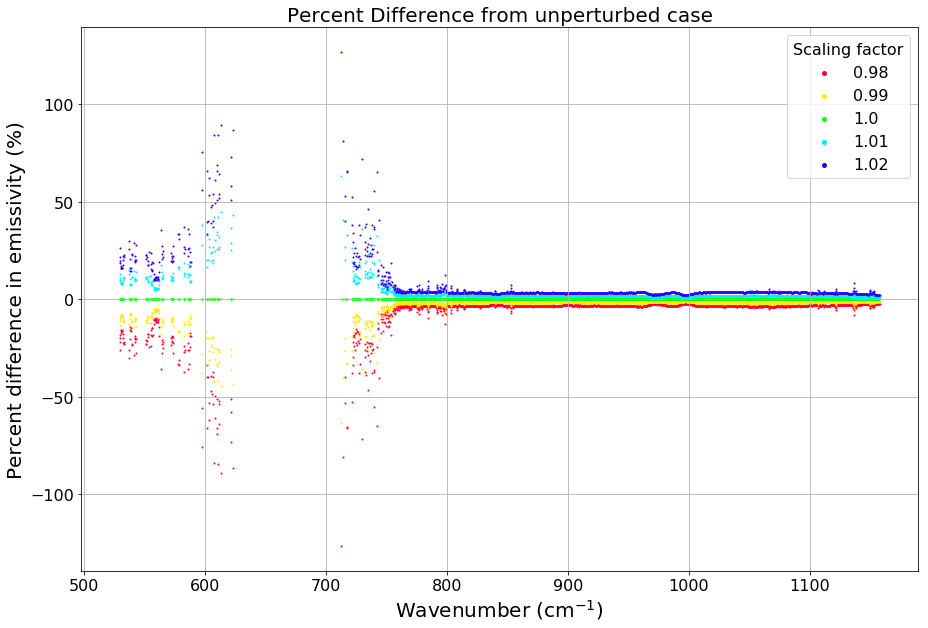

In [26]:
colors = cm.gist_rainbow(np.linspace(0, .8, len(perturbs_up)))

fig = plt.figure(figsize=(15,10))

for (l,name, color) in zip(perturbs_up, up_names, colors):
    perc = [(a-b)/b*100 for (a,b) in zip(l[1], perturbs_up[2][1])]
    plt.scatter(l[0], perc, s=1, label=name, c=color)

plt.title('Percent Difference from unperturbed case', fontsize=20)
plt.ylabel('Percent difference in emissivity (%)', fontsize=20)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
plt.tick_params(labelsize=16, labelcolor='black')
legend = plt.legend(fontsize=16, title='Scaling factor', markerscale=4)
plt.setp(legend.get_title(),fontsize=16)

#plt.ylim(0,1)
plt.grid()
fig.savefig('Graphs/Pert_Upwelling_percentage.png', dpi=600)
plt.show()

In [24]:
tau_files = sorted(glob.glob(path_sensitivity + '/' + 'Tau_' + '*'))

tau_names = []
perturbs_tau = []
for file in tau_files:
    file_end = os.path.basename(file)
    perturbs_tau.append(read_file(path_sensitivity, file_end, separator = '\t', rowstoskip=None, head=None))
    tau_names.append(file_end.strip('Tau_.csv'))

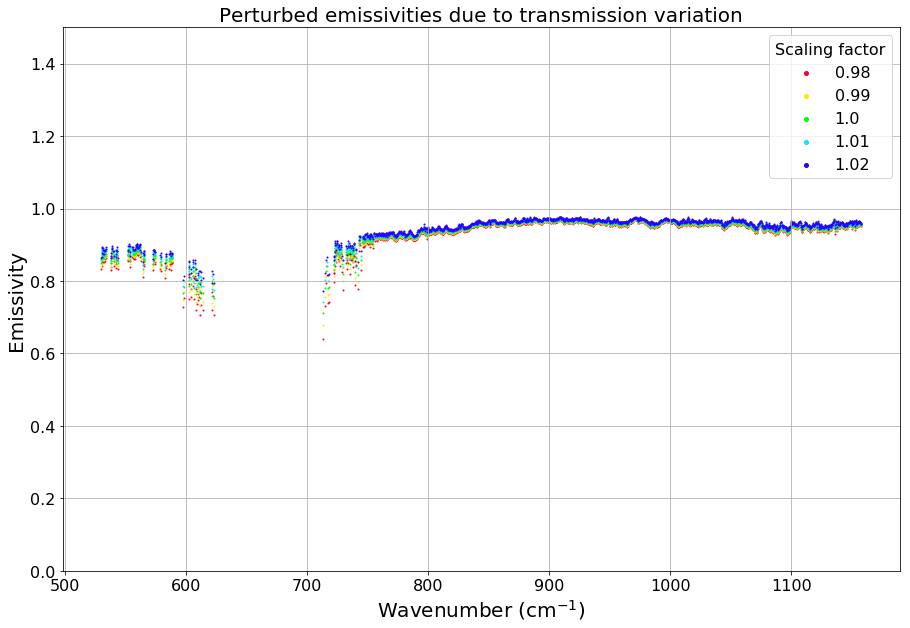

In [25]:
colors = cm.gist_rainbow(np.linspace(0, .8, len(perturbs_tau))) # last number is number of colours you want

fig = plt.figure(figsize=(15,10))

for (l,name, color) in zip(perturbs_tau, tau_names, colors):
    plt.scatter(l[0], l[1], s=1, label=name, c=color)
    
plt.title('Perturbed emissivities due to transmission variation', fontsize=20)
plt.ylabel('Emissivity', fontsize=20)
plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
plt.tick_params(labelsize=16, labelcolor='black')

legend = plt.legend(fontsize=16, title='Scaling factor', markerscale=4)
plt.setp(legend.get_title(),fontsize=16)
plt.ylim(0.,1.5)
plt.grid()
fig.savefig('Graphs/Pert_trans.png', dpi=600)
plt.show()

looks like downwelling which makes sense 